## Building a 1D CNN Model to Forecast ERCOT Wind Generation (24 hours)

### Step 1: Preprocess the Data

In [1]:
# Import libraries
import pandas as pd
import clean_data_for_cnn as scr
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
# Load the data
era5 = pd.read_csv('../clean_data/era5_wind_conditions_data.csv')
ercot = pd.read_csv('../clean_data/ercot_historical_wind_generation_data.csv')

# Clean the data
era5_clean, ercot_clean = scr.clean_data(era5, ercot)

# Combine both datasets into one dataframe
df = scr.combine_dfs(era5_clean, ercot_clean)

# Feature engineering: add new features
engineered_df = scr.add_interaction_features(df)

# Normalize the data
X_scaled, y_scaled, scaler_y = scr.normalize(engineered_df)

# Create sliding time windows for X and y
X_window, y_window = scr.create_time_windows(X_scaled, y_scaled)

# Split data into train-test sets
X_train, X_test, y_train, y_test = train_test_split(X_window, y_window)

Common Date/Time Range: 2021-01-01 01:00:00 to 2023-12-31 23:00:00

ERCOT dates not in ERA5 data: DatetimeIndex(['2021-01-01 00:00:00', '2021-03-14 03:00:00',
               '2021-09-20 01:00:00', '2021-09-20 02:00:00',
               '2021-09-20 03:00:00', '2021-09-20 04:00:00',
               '2021-09-20 05:00:00', '2021-09-20 06:00:00',
               '2021-09-20 07:00:00', '2021-09-20 08:00:00',
               '2021-09-20 09:00:00', '2021-09-20 10:00:00',
               '2021-09-20 11:00:00', '2021-09-20 12:00:00',
               '2021-09-20 13:00:00', '2021-09-20 14:00:00',
               '2021-09-20 15:00:00', '2021-09-20 16:00:00',
               '2021-09-20 17:00:00', '2021-09-20 18:00:00',
               '2021-09-20 19:00:00', '2021-09-20 20:00:00',
               '2021-09-20 21:00:00', '2021-09-20 22:00:00',
               '2021-09-20 23:00:00', '2021-09-21 00:00:00',
               '2021-11-09 00:00:00', '2022-03-13 03:00:00',
               '2022-11-07 00:00:00', '2023-03-1

In [18]:
df.describe()

,temp_2m,wind_u_100m,wind_v_100m,wind_generation,hour_sin,hour_cos,day_sin,day_cos,wind_gen_lag1,wind_gen_lag2,wind_gen_roll3,wind_gen_std3,wind_gen_roll6,wind_gen_std6,wind_gen_roll24,wind_gen_std24
count,26255.000000,26255.000000,26255.000000,26248.000000,2.625500e+04,2.625500e+04,2.625500e+04,26255.000000,26247.000000,26246.000000,26232.000000,26232.000000,26208.000000,26208.000000,26064.000000,26064.000000
mean,293.869547,-0.906688,2.070515,11824.754105,5.908848e-06,-2.382276e-05,8.972233e-04,0.000123,11824.524048,11824.265633,11821.120521,838.183567,11816.323271,1447.957727,11797.005801,3328.256012
std,8.704326,2.333943,3.871963,6277.289076,7.071189e-01,7.071216e-01,7.068355e-01,0.707404,6277.298004,6277.277980,6214.414226,679.489408,6067.613364,996.272682,5172.489713,1451.500131
min,261.772067,-8.340492,-11.793822,37.960000,-1.000000e+00,-1.000000e+00,-9.999907e-01,-0.999963,37.960000,37.960000,95.283333,3.982867,225.396667,32.866365,1269.804583,283.024348
25%,287.884717,-2.520321,-0.308692,6422.410000,-7.071068e-01,-7.071068e-01,-7.055836e-01,-0.708627,6422.240000,6422.070000,6501.820000,336.790268,6638.911250,701.127421,7645.384479,2205.384038
50%,294.898725,-1.103069,2.546047,11512.910000,1.224647e-16,-1.836970e-16,6.432491e-16,0.004304,11512.510000,11512.380000,11508.713333,655.170145,11528.507500,1203.822233,11623.138125,3227.518485
75%,300.295381,0.437055,4.942537,17043.937500,7.071068e-01,7.071068e-01,7.055836e-01,0.702527,17043.895000,17043.675000,16950.171667,1147.698760,16784.355417,1967.550787,15528.023333,4297.169369
max,312.515675,9.432351,11.398435,31981.490000,1.000000e+00,1.000000e+00,9.999907e-01,1.000000,31981.490000,31981.490000,26781.253333,9782.371466,26606.873333,7547.886522,25218.939167,10558.506911


Features: `wind_u_100m`, `wind_v_100m`, `temp_2m`, `wind_generation`, `hour_sin`, `hour_cos`, `day_sin`, `day_cos`, `wind_gen_lag1`, `wind_gen_lag2`, `wind_gen_roll3`, `wind_gen_std3`, `wind_gen_roll6`, `wind_gen_std6`, `wind_gen_roll24`, `wind_gen_std24`

Target: `wind_generation` (MW)

### Step 2: Build 1D CNN that predicts the next 24 hours of data 

In [6]:
# Import libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

Initialize the Model

In [4]:
# Initialize a Sequential model (layers will be stacked)
model = Sequential()

# 1D Convolutional Layer:
# Applies 64 filters (kernels), each of size 3, across the temporal axis
# Learns short-term temporal patterns in the input sequence (windows)
# 'relu' activation introduces non-linearity
# input_shape = (hr_steps, num_features) = (24, 16)
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_window.shape[1], X_window.shape[2])))

# MaxPooling Layer:
# Downsamples the output of Conv1D by taking the maximum value in each pool of 2 time steps
# Reduces dimensionality, speeds up computation, helps prevent overfitting
model.add(MaxPooling1D(pool_size=2))


# Feedforward Layers (process learned features)

model.add(Flatten())                           # Flatten Layer: Converts 2D output from previous layer into 1D vector
model.add(Dense(64, activation='relu'))        # Dense Layer: A fully connected layer with 64 neurons and ReLU activation. Processes learned features
model.add(Dropout(0.2))                        # Dropout Layer: Randomly drops (sets to zero) 20% of neurons during training to prevent overfitting
model.add(Dense(1))                            # Output Layer: Single neuron with no activation. Single linear output that predicts next hour's wind generation

# Compile the model with adam (adaptive learning rate optimizer)
model.compile(optimizer='adam', loss='mse')

# Summary of model architecture
model.summary()

c:\Users\kater\miniconda3\envs\nrel_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 22, 64)         │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 704)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,977 (183.50 KB)

 Trainable params: 46,977 (183.50 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Training set is all data except the last 24 hours
X_train = X_window[:-24]
y_train = y_window[:-24]

# Testing set is only the last 24 hours
X_test = X_window[-24:]
y_test = y_window[-24:]

In [7]:
# Use EarlyStopping
early_stop = EarlyStopping(patience=3, restore_best_weights=True)
model.fit(X_train, y_train, 
          epochs=30, 
          batch_size=32,
          validation_split=0.1,
          callbacks=[early_stop])

# Train the model without the validation split
history = model.fit(X_train, y_train, epochs=30, batch_size=32)

# Make predictions
y_pred = model.predict(X_test)

# Inverse scale of y-values before calculating RMSE
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"24-hour forecast RMSE: {rmse:.2f} MW\n")

mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100
print(f"MAPE: {mape:.2f}%")

Epoch 1/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0275 - val_loss: 0.0056
Epoch 2/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0066 - val_loss: 0.0044
Epoch 3/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.0053 - val_loss: 0.0039
Epoch 4/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0046 - val_loss: 0.0036
Epoch 5/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 6/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0042 - val_loss: 0.0036
Epoch 7/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 8/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 9/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 10/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 11/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 12/30
732/732 ━━━━━━━━━━━━━━━━━━━━ 10s 8m

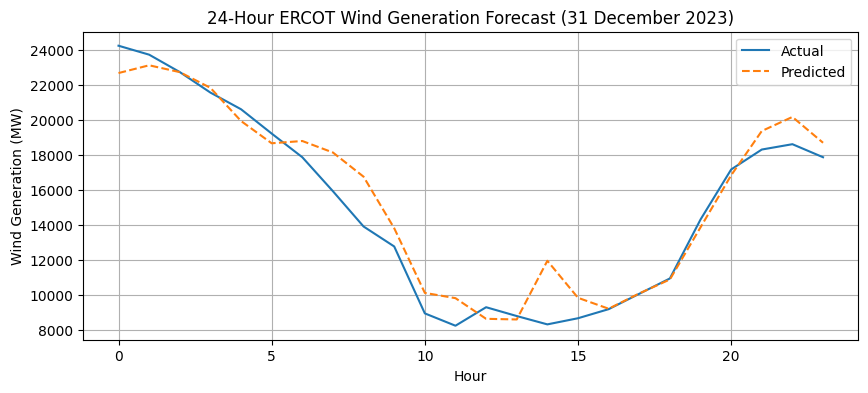

In [11]:
# Plot actual vs. predicted
plt.figure(figsize=(10, 4))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted', linestyle='--')
plt.title('24-Hour ERCOT Wind Generation Forecast (31 December 2023)')
plt.xlabel('Hour')
plt.ylabel('Wind Generation (MW)')
plt.legend()
plt.grid(True)
plt.show()


#### Visualize CNN architecture

In [ ]:
from tensorflow.keras.utils import plot_model
import visualkeras

# Downloads a visualization of model layers
visualkeras.layered_view(model, legend=True, draw_volume=True).show()

#### Loss Curve: check for over/underfitting

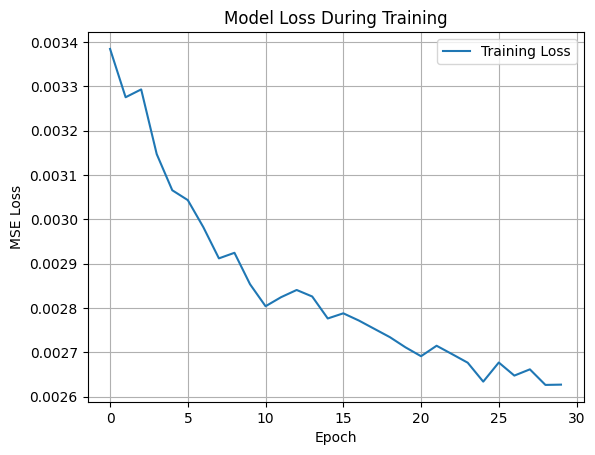

In [ ]:
# Plot the MSE for each epoch
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')

# Annotations
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

### Step 3: Cross Validation

In [ ]:
# Import libraries
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import root_mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

Doing the CV manually since I couldn't figure out how to resolve dependency conflicts with scikeras, numpy, and sklearn

In [ ]:
# Define the model builder function
def build_model(input_shape, num_filters=64, kernel_size=3, learning_rate=0.001):
    """
    Creates a 1D CNN model with different parameters for time series regression. 

    Params:
        - input_shape (tuple): shape of input data (time_steps, num_features)
        - num_filters (int, optional): number of convolutional filters
        - kernel_size (int, optional): size of the convolutional window
        - learning_rate (float, optional): learning rate used by the Adam optimizer


    Returns: model_cv (tf.keras.Model): a compiled Keras Sequential model ready for training.
    """
    model_cv = Sequential([
        Input(shape=input_shape),
        Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(1)
    ])
    model_cv.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model_cv

# Initialize time series CV (TimeSeriesSplit respects temporal structure of data)
tscv = TimeSeriesSplit(n_splits=5)

# Initialize list to store RMSE scores for each fold
rmse_scores_cv = []

# Cross-validation loop
# Loop through each fold of the TimeSeriesSplit
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_window)):

    # Split data into training and validation set (indices from TimeSeriesSplit)
    X_train, X_val = X_window[train_idx], X_window[val_idx]
    y_train, y_val = y_window[train_idx], y_window[val_idx]

    # Build model with current input shape (based on the training data)
    model_cv = build_model(input_shape=X_train.shape[1:])

    # EarlyStopping if loss doesn't improve for 3 epochs (helps prevent overfitting)
    early_stop = EarlyStopping(patience=3, restore_best_weights=True)

    # Train model
    model_cv.fit(X_train, y_train, 
              epochs=10, 
              batch_size=32, 
              validation_data=(X_val, y_val), 
              callbacks=[early_stop],
              verbose=0)

    # Predict values for validation set
    y_pred = model_cv.predict(X_val).flatten()

    # Calculate RMSE for current fold and add to list
    rmse = root_mean_squared_error(y_val, y_pred)
    rmse_scores_cv.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse:.4f}")

print(f"\nAverage RMSE across folds: {np.mean(rmse_scores_cv):.4f}")


136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold 1 RMSE: 0.0686
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 2 RMSE: 0.0628
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 3 RMSE: 0.0526
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Fold 4 RMSE: 0.0593
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Fold 5 RMSE: 0.0524

Average RMSE across folds: 0.0592


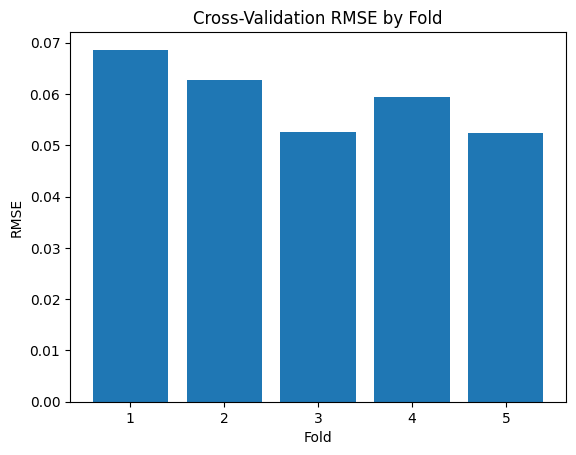

In [ ]:
# Plot error for each CV fold
folds = list(range(1, len(rmse_scores_cv) + 1))
plt.bar(folds, rmse_scores_cv)
plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.title("Cross-Validation RMSE by Fold")
plt.show()

Ended up sticking with the original model after cross validation so did not retrain a new model. For future work, I can do more intensive hyperparameter tuning to improve model performance.

### Step 4: Evaluate Model on 2025 Data (just for fun!)

##### Preprocess the validation data

*Date range from March 1st, 2025 to April 17, 2025*

In [14]:
# Load the data
era5_validation = pd.read_csv('../clean_data/era5_validation_wind_conditions_data.csv')
ercot_validation = pd.read_csv('../clean_data/ercot_validation_historical_wind_generation_data.csv')

# Clean the data
era5_clean, ercot_clean = scr.clean_data(era5_validation, ercot_validation)

# Combine both datasets into one dataframe
df_val = scr.combine_dfs(era5_clean, ercot_clean)

# Feature engineering: add new features
engineered_df_val = scr.add_interaction_features(df_val)

# Normalize the data
X_scaled_val, y_scaled_val, scaler_y_val = scr.normalize(engineered_df_val)

# Create sliding time windows for X and y
X_window_val, y_window_val = scr.create_time_windows(X_scaled_val, y_scaled_val)

# Get the last 24 data points to make predictions on
X_val_last24 = X_window_val[-24:]
y_val_last24 = y_window_val[-24:]

Common Date/Time Range: 2025-03-01 01:00:00 to 2025-04-17 02:00:00

ERCOT dates not in ERA5 data: DatetimeIndex(['2025-03-01 00:00:00', '2025-03-09 02:00:00',
               '2025-03-09 03:00:00'],
              dtype='datetime64[ns]', freq=None)

Checking -- ERCOT dates not in ERA5 data: DatetimeIndex([], dtype='datetime64[ns]', freq=None)

Dataframe Shape: (1174, 4)
Added Feature: Time of Day and Time of Year
Description:   Since wind patterns often follow dinural cycles, it's best to have time as a function of sin/cos to avoid discontinuities

Added Feature: Wind Generation Lag
Description:   This helps the CNN 'remember' recent values

Added Feature: Rolling Means/Standard Deviations of Wind Generation
Description:   This helps smooth noisy data and capture trends

Dropped some missing values
Shape: (1105, 16)

X_scaled shape: (1105, 9)
y_scaled shape: (1105, 1)

Window Shapes:
X: (1081, 24, 9), y: (1081, 1)



##### Predict on the validation set

In [15]:
# Predict using your trained model
y_pred_last24 = model.predict(X_val_last24)
y_pred_last24_inv = scaler_y.inverse_transform(y_pred_last24)
y_true_last24_inv = scaler_y.inverse_transform(y_val_last24)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_true_last24_inv, y_pred_last24_inv))
print(f"Final 24-hour forecast RMSE on validation set: {rmse:.2f} MW")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Final 24-hour forecast RMSE on validation set: 3188.48 MW


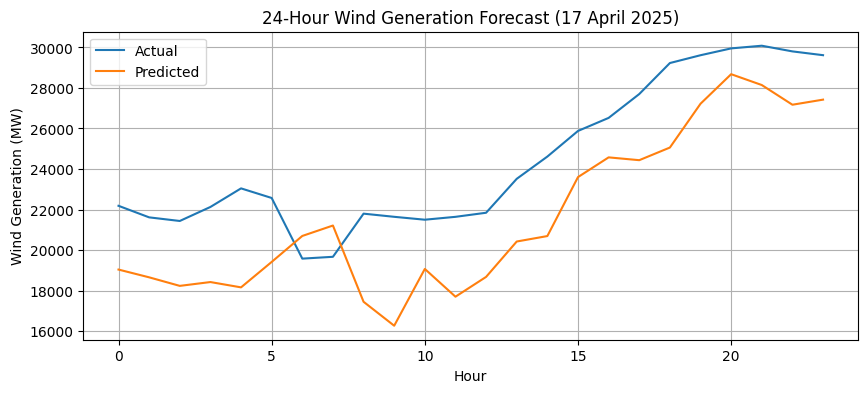

In [16]:
# Plot actual vs. predicted
plt.figure(figsize=(10, 4))
plt.plot(y_true_last24_inv, label='Actual')
plt.plot(y_pred_last24_inv, label='Predicted')
plt.title('24-Hour Wind Generation Forecast (17 April 2025)')
plt.xlabel('Hour')
plt.ylabel('Wind Generation (MW)')
plt.legend()
plt.grid(True)
plt.show()

For not having trained on any 2025 data, let alone 2024 data, the model performed decently well! For future work, I'd like to create a pipeline that periodically updates the training data and retrains the model. This will allow the model to perform better when predicting a real day ahead in the future!